In [4]:
from collections import OrderedDict
from time import time
import sqlite3

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from sklearn.cross_validation import train_test_split

from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

from IPython.html.widgets import interactive, fixed

sns.set(style="darkgrid", palette="muted")
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 10, 6
np.random.seed(0)

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
## Interactive magics - comment out if running from another script
%matplotlib inline
%qtconsole --colors=linux --ConsoleWidget.font_size=12 --ConsoleWidget.font_family='Consolas'

In [5]:
data= pd.read_csv('big_data.csv')
train, test = train_test_split(data, train_size = 0.8)

In [6]:
dforigtrain = train
dforigtrain.rename(columns=lambda x: '_'.join([x.strip() for x in x.lower().split()]), inplace=True)
dforigtrain['orig_set'] = 'train'
print(dforigtrain.shape)
dforigtrain.head()

(136673, 433)


,caseid,t010101,t010102,t010199,t010201,t010299,t010301,t010399,t010401,t010499,...,t181899,t189999,t500101,t500103,t500104,t500105,t500106,t500107,t509989,orig_set
168305,168306.0,598.0,0.0,0.0,30.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
98916,98917.0,664.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,train
96892,96893.0,755.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
134874,134875.0,670.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
85182,85183.0,660.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,...,0.0,25.0,130.0,0.0,0.0,0.0,0.0,0.0,0.0,train


In [7]:
dforigtest = test
dforigtest.rename(columns=lambda x: '_'.join([x.strip() for x in x.lower().split()]), inplace=True)
dforigtest['orig_set'] = 'test'
print(dforigtest.shape)
dforigtest.head()

(34169, 433)


,caseid,t010101,t010102,t010199,t010201,t010299,t010301,t010399,t010401,t010499,...,t181899,t189999,t500101,t500103,t500104,t500105,t500106,t500107,t509989,orig_set
3606,3607.0,420.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,test
67433,67434.0,480.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,test
139148,139149.0,600.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,test
108282,108283.0,570.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,test
63181,63182.0,500.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,test


In [8]:
dfraw = pd.concat((dforigtrain,dforigtest), axis=0)
dforigset = dfraw['orig_set']
print(dforigset.shape)

dfa = dfraw[[c for c in dfraw.columns.values.tolist() if c != 'orig_set']]
df = dfa.sample(n=5000)
print(df.shape)

(170842,)
(5000, 432)


In [9]:
scaler = StandardScaler().fit(df.iloc[:,1:])
dfs = pd.DataFrame(scaler.transform(df.iloc[:,1:]), index=df.index, columns=df.columns[1:])

In [10]:
u, s, vt = svd(dfs)

Variance preserved by first 100 components == 45.04%
Variance preserved by first 5 components == 4.45%


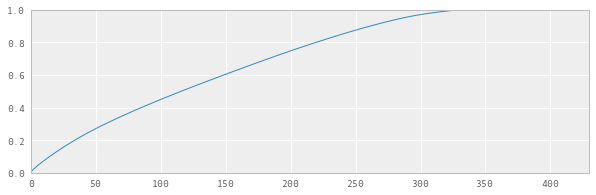

In [11]:
idx = ~np.isnan(s)
xtrans = np.dot(u[:,idx], np.diag(s[idx]))
expvar = np.var(xtrans, axis=0)
fullvar = np.var(dfs, axis=0)
expvarrat = expvar/fullvar.sum()
ax = pd.Series(expvarrat.cumsum()).plot(kind='line', figsize=(10,3)).set_ylim([0,1])
print('Variance preserved by first 100 components == {:.2%}'.format(expvarrat.cumsum()[100]))
print('Variance preserved by first 5 components == {:.2%}'.format(expvarrat.cumsum()[5]))

Variance preserved by first 50 components == 26.22%


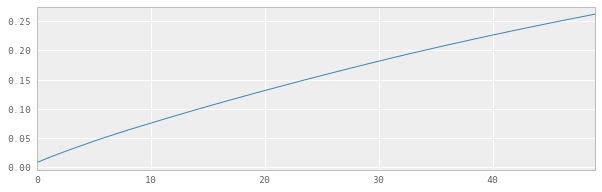

In [12]:
ncomps = 50
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(dfs)
Y = svd.fit_transform(dfs) 
ax = pd.Series(svd_fit.explained_variance_ratio_.cumsum()).plot(kind='line', figsize=(10,3))
print('Variance preserved by first 50 components == {:.2%}'.format(
        svd_fit.explained_variance_ratio_.cumsum()[-1]))

In [13]:
dfsvd = pd.DataFrame(Y, columns=['c{}'.format(c) for c in range(ncomps)], index=df.index)
print(dfsvd.shape)
dfsvd.head()

(5000, 50)


,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c40,c41,c42,c43,c44,c45,c46,c47,c48,c49
57852,0.377685,-0.613992,-0.919354,-1.023229,0.900829,-0.058056,-0.876116,-0.307417,0.932007,-0.527155,...,-0.422167,-0.057044,0.642707,-0.205083,0.098730,0.346476,0.102432,0.033958,-0.194964,0.224811
64876,-0.137843,0.141987,-1.361398,1.630528,-6.099647,2.861542,1.936205,2.041992,4.131712,2.365728,...,0.494139,0.349580,0.042623,0.719687,0.334321,-0.023750,-0.380929,0.651022,0.228925,-0.695215
123349,-0.422897,0.363473,0.147132,0.136496,-1.301046,0.466305,0.535025,0.382023,0.109761,0.217445,...,0.417443,-0.693548,0.311923,-0.918453,-0.438418,0.321845,0.076197,-0.342546,-0.003968,0.060000
58010,1.433821,-2.569134,-0.691294,-1.590835,1.227674,-0.103301,0.223147,2.253495,-3.985544,2.214100,...,-0.204463,-0.863774,0.182888,0.416101,1.022715,-1.065317,0.360173,-0.528577,0.937353,-0.877323
166160,0.024461,-0.230883,-0.503901,-0.482096,-0.039608,0.087457,-0.231514,0.004495,0.238872,-0.306850,...,-0.465650,-0.010679,0.236593,-0.783763,0.372216,0.107010,-0.154472,0.085817,-0.397476,0.222396


In [14]:

plotdims = 5
ploteorows = 1
dfsvdplot = dfsvd[svdcols].iloc[:,:plotdims]
dfsvdplot['caseid'] = df['caseid']
ax = sns.pairplot(dfsvdplot.iloc[::ploteorows,:], hue='caseid', size=1.8)

NameError: name 'svdcols' is not defined